<a href="https://colab.research.google.com/gist/ankojubhanuprakash/6f7b0ff99006782564e67f450dc61fe3/1612519168_neuron-models-simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install brian2

     |████████████████████████████████| 1.2MB 8.0MB/s 
     |████████████████████████████████| 5.9MB 18.4MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp36-cp36m-linux_x86_64.whl size=1257534 sha256=3caed292cb5e53bebdafe87c0f57ad4ec9ff97d237859e4aec2aa7c830491133
  Stored in directory: /root/.cache/pip/wheels/5d/4b/cf/ef50e71df5479d67f981cbb17b1d842381019d27ba144d57de
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [2]:
pip install neurodynex3

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 163kB 9.5MB/s 


In [3]:
pip install -U scikit-learn

     |████████████████████████████████| 22.2MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [5]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [159]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [7]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

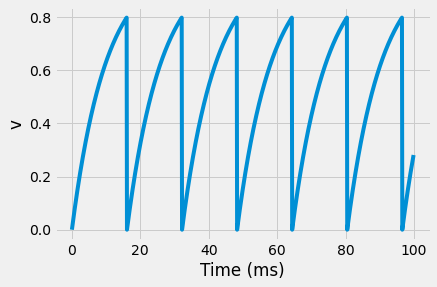

In [8]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

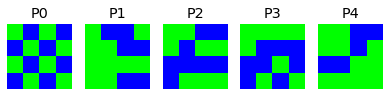

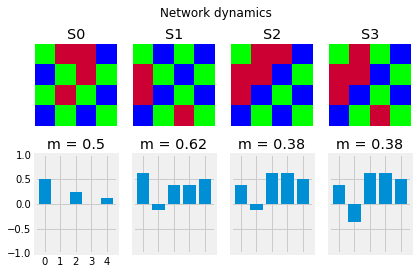

In [9]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model
### source : Class notes

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

In [10]:
def get_patterns(pattern_size,n_patterns): 
  pattern_list = []
  for p in range(n_patterns):
    neurons = np.array([[0]*pattern_size]*pattern_size)
    for i in range(pattern_size):
      for j in range(pattern_size):
        if (np.random.rand()>0.5):
          neurons[i][j] = 1
        else:
          neurons[i][j] = -1
    pattern_list.append(neurons)
  return pattern_list
def get_cue(plist,i):
  return plist[i]
def  calculate_weights(pattern_list, pattern_size):
  weights = np.array([[0]*pattern_size**2]*pattern_size**2)
  for p in range(len(pattern_list)):   
    for i in range(pattern_size**2):
      i1,j1 = reverse_map_indices(i,pattern_size)
      for j in range(pattern_size**2):      
        i2,j2 = reverse_map_indices(j,pattern_size)
        weights[i][j] += pattern_list[p][i1][j1]*pattern_list[p][i2][j2]
        #print(weights)
  return weights/pattern_size**2

def map_indices(i,j,pattern_size):
  return pattern_size*i+j  

def reverse_map_indices(idx,pattern_size):
  return int(idx/pattern_size), idx%pattern_size

def network_evolution(state,weights,pattern_size):
  #print(pattern_size)
  tempcopy = deepcopy(state)
  for i in range(pattern_size**2):
    temp=0
    for j in range(pattern_size**2):
      temp+= weights[i][j]* tempcopy[reverse_map_indices(j,pattern_size)]
    ihat,jhat = reverse_map_indices(i,pattern_size)    
    tempcopy[ihat][jhat]=np.sign(np.sum(temp))
  return tempcopy 

def perturb_pattern(pattern,nflips,pattern_size):
  fliplocs = np.random.randint(0,(pattern_size**2)-1,nflips)
  #print(fliplocs)
  for f in fliplocs:
    i,j = reverse_map_indices(f,len(pattern))
    pattern[i][j] = - pattern[i][j]
  return pattern


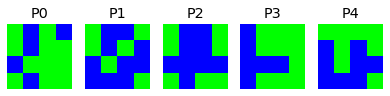

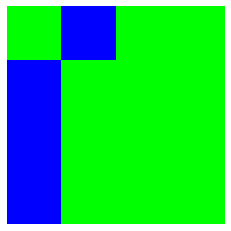

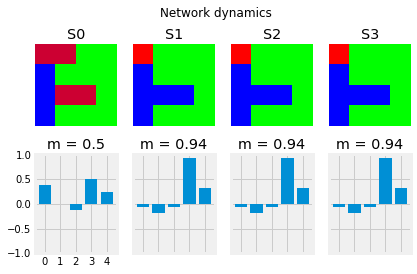

0.9375

In [11]:
def Hopfield_exec(pr_pattern_size,no_pattern,cue_id,cue_detor,plot_flg ):
  plist = get_patterns(pr_pattern_size,no_pattern)
  pattern_size = pr_pattern_size
  #plot_tools.plot_pattern_list(plist)

  cue = deepcopy(plist)
  cue_ref_id = cue_id
  pertubation = cue_detor
  S = perturb_pattern(cue[cue_ref_id ],pertubation,pr_pattern_size)
  #print(S)
  wghts = calculate_weights(plist, pattern_size)
  #print(wghts)

  state_list =[S]
  #state_list.append(S)
  #print(state_list)
  #plot_tools.plot_pattern(S)
  for i in range(3):
      state_list.append(network_evolution(S,wghts,pattern_size))
#      state_list.append(S)

  if plot_flg == True:
    plot_tools.plot_pattern_list(plist)
    #print(state_list[0])
    #plot_tools.plot_pattern_list(state_list)
    
    plot_tools.plot_pattern(state_list[0])
    plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=cue_ref_id , suptitle="Network dynamics")
  
  return pattern_tools.compute_overlap(plist[cue_ref_id], state_list[3])



Hopfield_exec(4,5,3,8,True)

# the informativeness of the cue

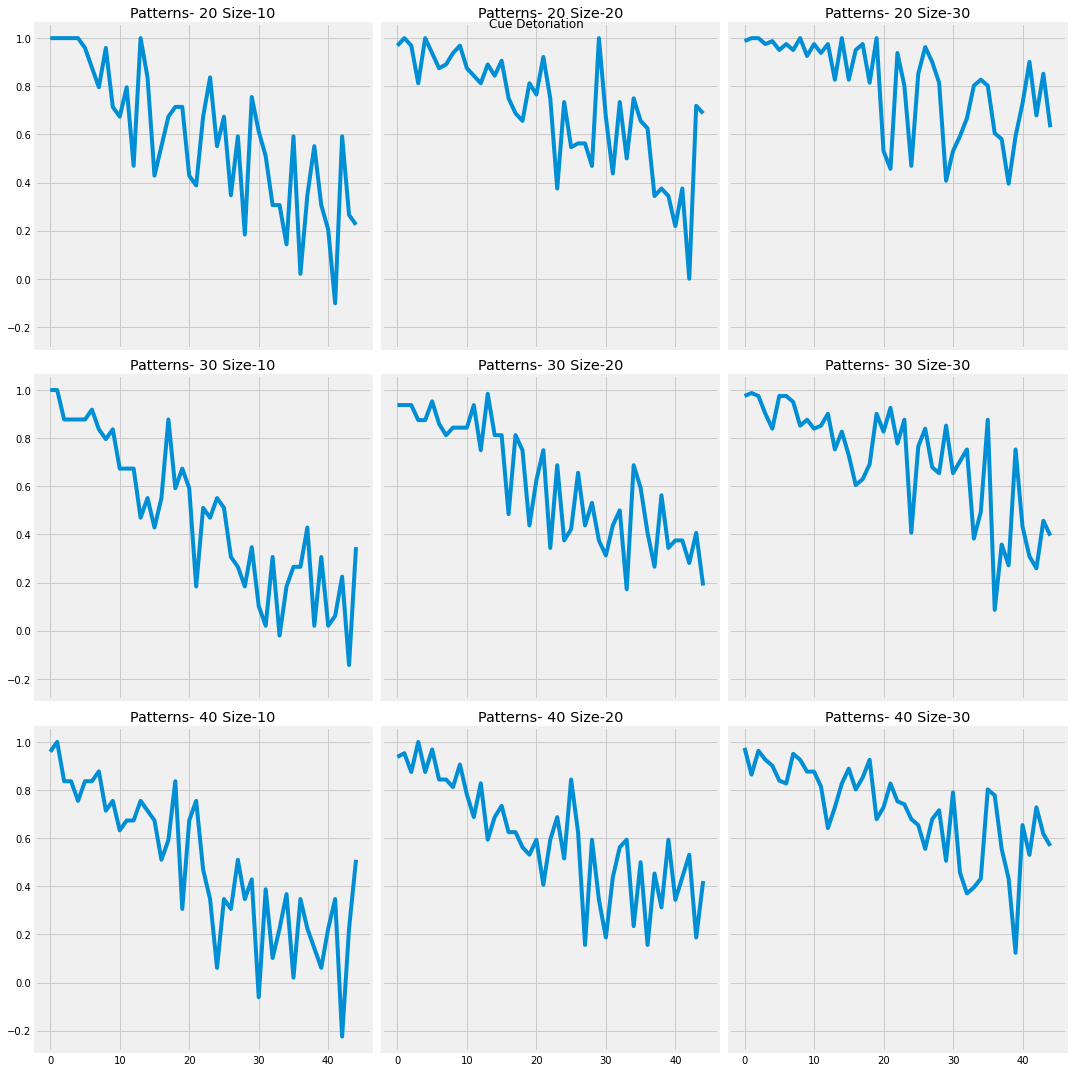

In [177]:
fig, axs = plt.subplots(3,3,sharex=True, sharey=True)
fig.suptitle('Cue Detoriation')
for a in range(3):
  for b in range(3):
    x,y=[],[]
    for i in range(45):
      x+=[i]
      y+=[Hopfield_exec(pr_pattern_size = 7+(b*1),no_pattern=20+(10*a),cue_id=np.random.randint(low=0,high=5),cue_detor = i,plot_flg=False)]
    axs[a,b].plot(x, y,)
    titlea =  "Patterns- "+str(20+10*a)+" Size-"+str(10*(b+1))
    axs[a,b].set_title(titlea)  
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout() 
plt.show()    


## As cue perturbation increases, confidence level decreases.
## As size of pattern increases, confidence level increases. that is with increase in patter size, cue detoriation affected confidence less.
## Increase in No of patterns, decrease confidence ; but i did not see significant behaviour in decrease of confidence.
### Note - behaviour is stochastic.   

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# Answer - 4


# Mnist data


In [30]:
import numpy as np
import skimage.measure

In [31]:
# loaded frm google colab
mnistdata=pd.read_csv('sample_data/mnist_train_small.csv')
print(mnistdata.shape)
#segregating labels and target
xdf,ydf=mnistdata.drop('6',axis=1),mnistdata['6']
#describe 
xdf.iloc[:,0:100].describe().T


(19999, 785)


,count,mean,std,min,25%,50%,75%,max
0,19999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0.1,19999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0.2,19999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0.3,19999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0.4,19999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
0.95,19999.0,5.610631,33.423950,0.0,0.0,0.0,0.0,255.0
0.96,19999.0,7.498625,38.226671,0.0,0.0,0.0,0.0,255.0
0.97,19999.0,9.665533,43.066596,0.0,0.0,0.0,0.0,255.0
0.98,19999.0,12.172259,48.165228,0.0,0.0,0.0,0.0,255.0


#  function that converts MNIST digit data to patterns used in this simulation

In [136]:
# function to convert mnist to hopfield network pattern
def cnvert_Mnist_image2pattern(pattern,plotflg):
  pattern = np.array(pattern)  
  pattern = pattern.reshape(28,28)
  #croppig operation
  pattern= pattern[4:24,4:24]
  #cropping end
  #pooling operation
  #pattern=skimage.measure.block_reduce(pattern, (2,2), np.max)
  pattern = np.where(pattern >= 100, 1, -1)
  if plotflg == True:
    plot_tools.plot_pattern(pattern)
  return pattern  



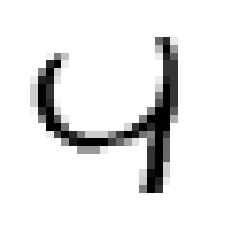

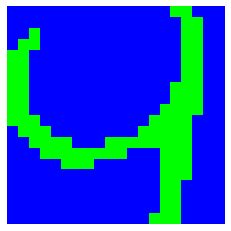

(20, 20)


In [137]:
## random image to display
sample_img= np.array(xdf.iloc[20,:])
sample_img=sample_img.reshape(28,28)
plt.imshow(sample_img, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
ganeratedpattern=cnvert_Mnist_image2pattern(sample_img,True)
## pattern with reference to 
print(ganeratedpattern.shape)

# Can you write an MNIST classifier using the Hopfield network?Can you characterize its performance using F-score, and compare with classical and deep supervised learning methods? 
steps - 

### steps for Hopfield classifier
### 1. Collect Aggregate measure of samples for each digit, and construct 10 patterns. Here I used 100,500,1000 samples. i used mean as aggregated measure.
### 2. Based on  three samples, three models were trained.
### 3.Calucualted Macro F1 score and accuracy score for 3 models. and trained Deep supervised and Support Vector machine model, with 500 sample training data(this data is same which is used in one of the HopField) 

### As per scores, top performer Deep superised , Hopfield goes second and last calssical Model. besides order of performance, we can see Hopfield network suffered from bias towards digit 1. And SVN has strong bias towards digit 9. 
 
### Possible Reason - 
### Poor custom function, which converts Image to pattern needed for Hopfield network. Proper prepeocessing of the image like removing trailing and leading zeros, may help. I tried some preprocessing like cetering the digit and max pooling, but it did not give any luck in improving performance.





# Train and Test Evaluate hopfield network
## load and generate patterns

In [138]:
def Load_Train(no_images):
  sample_df_list=[]
  for i in range(10):
    sample_df_list.append(mnistdata[mnistdata['6']==i].sample(no_images))
  sample_df= pd.concat(sample_df_list)
  sample_df.reset_index(inplace=True)
  hopfield_df=sample_df.groupby('6').median() #hopfield=hfld
  hopfield_df.drop('index',axis=1,inplace=True)
  hopfield_df.reset_index(inplace=True)
  # get patterns and weights
  image_size=20
  hpf_patterlist=[]
  for row in hopfield_df.drop('6',axis=1).iterrows():
    temp= np.array(row[1])
    temp=temp.reshape(28,28)
    temp=cnvert_Mnist_image2pattern(temp,False)
    hpf_patterlist.append(temp)
    #hpf_patterlist.append(temp2)
  plot_tools.plot_pattern_list(hpf_patterlist)  
  plot_tools.plot_pattern(hpf_patterlist[4])
  # Get Pattern weights for Hopfield neywork
  hopfld_wghts = calculate_weights(hpf_patterlist, image_size)

  return sample_df,hpf_patterlist,hopfld_wghts

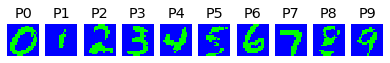

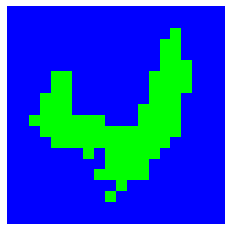

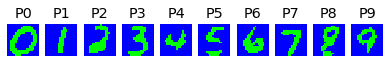

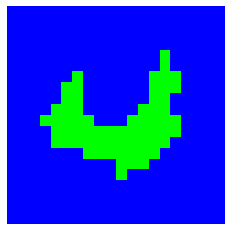

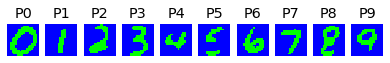

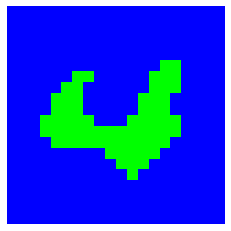

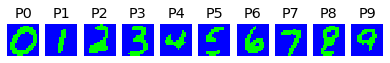

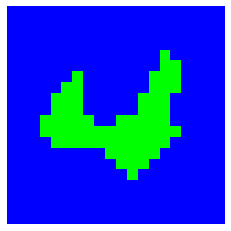

In [140]:
hfTrain,hfPattern,hfWeights=Load_Train(10)
hfTrain_100,hfPattern_100,hfWeights_100=Load_Train(100)
hfTrain_500,hfPattern_500,hfWeights_500=Load_Train(500)
hfTrain_1000,hfPattern_1000,hfWeights_1000=Load_Train(1000)



# function for evolution and evaluation



In [157]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score,accuracy_score,plot_confusion_matrix,classification_report
#hopfld_wghts = calculate_weights(hpf_patterlist, 14)
def evolvetin(hpf_patterlist,hopfld_wghts,test_specimen, plotflg):
  #ecolve and predict
  img_size = 20
  #get_image from specimen and send to concert mnist to pattern
  S = np.array(test_specimen[1][1:])
  # convert to hopfield pattern
  S=cnvert_Mnist_image2pattern(S,False)
  
  #print(S.shape)
  #plot_tools.plot_pattern(S)
  #perform evolution
  state_list =[S]
  
  for i in range(8):
      state_list.append(network_evolution(S,hopfld_wghts,img_size)) 
  overlap_score = []
  for i in range(0,10):
    score = pattern_tools.compute_overlap(hpf_patterlist[i], state_list[3])
    overlap_score.append(score)
  score = np.array(score)
  #print(score)
  if plotflg == True:
    plot_tools.plot_pattern(state_list[3])
  #print(overlap_score)  
  return np.argmax(overlap_score)  

def evaluate(stored_pattern,trained_weights,no_ofsamples):
  mnist_test_data=pd.read_csv('sample_data/mnist_test.csv')
  mnist_test_data.rename(columns={'7':'ytest'},inplace=True)
  mnist_test_data=mnist_test_data.sample(no_ofsamples)
  ytpred=[]
  for row in mnist_test_data.iterrows():
    ytpred.append(evolvetin(hpf_patterlist,hopfld_wghts,row,False))
  ytest=mnist_test_data['ytest'] 
  # plot and print metrics
  hopfld_f1score = f1_score(ytest, ytpred, average='weighted')
  print('Macro f1 score for hop field network  '+str(hopfld_f1score))
  print('Accuracy Score for Hop Field Net '+ str(accuracy_score(ytest, ytpred)))
  hopfld_confsnmatrix = confusion_matrix(ytest, ytpred,labels= [i for i in range(10) ])
  ConfusionMatrixDisplay(confusion_matrix=hopfld_confsnmatrix,display_labels=[i for i in range(10) ]).plot()
  return mnist_test_data




## Test Hopfieldnetwork

### Three plots of confusion matrix, of corresponding samples used for training 100, 500, 1000.  

Macro f1 score for hop field netwoek is 0.12409941782355577
Accuracy Score for Hop Field Net 0.215
Macro f1 score for hop field netwoek is 0.11629264030988168
Accuracy Score for Hop Field Net 0.2
Macro f1 score for hop field netwoek is 0.12231323378869709
Accuracy Score for Hop Field Net 0.2


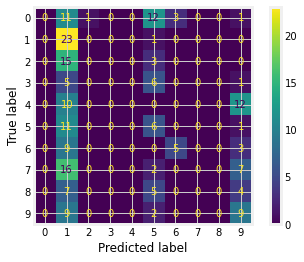

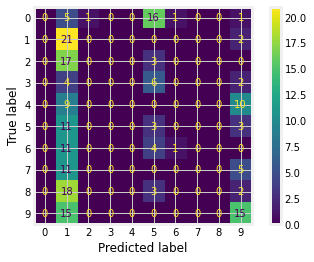

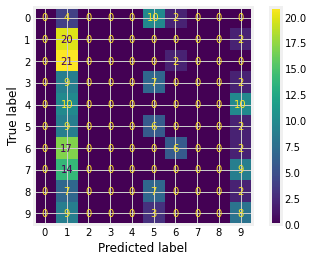

In [143]:
#evaluate 100 sample pattern 
test_data_a = evaluate(hfPattern_100,hfWeights_100,200)
#evaluate 500 sample pattern
testdata_b=evaluate(hfPattern_500,hfWeights_500,200)
# evaluate 1000 sample pattern
test_data_c=evaluate(hfPattern_1000,hfWeights_1000,200)


# Deep supervised model

In [144]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, Flatten, Reshape, MaxPool2D
import keras
from tensorflow.python.keras.callbacks import TensorBoard

In [145]:
model = Sequential()
model.add(Reshape((28,28,1),input_shape=(784,)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',strides=(1,1)))
#26x26x32
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'))
#24x24x64
model.add(MaxPool2D(pool_size=(2,2)))
#6x6x64
model.add(Dropout(0.25))
#Flatten the Output
model.add(Flatten())
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [146]:
train_x,train_y = hfTrain_500.iloc[:,2:],keras.utils.to_categorical(hfTrain_500.iloc[:,1:2], num_classes=None, dtype='float32')
test_x,test_y = testdata_b.iloc[:,1:],keras.utils.to_categorical(testdata_b.iloc[:,0:1], num_classes=None, dtype='float32')

In [147]:
model.fit(train_x,train_y,epochs=30,batch_size=None,
          validation_data=(test_x,test_y),
         callbacks=[TensorBoard(log_dir='/tmp/mnist/keras/cnn/v1')])

Epoch 1/30
157/157 [==============================] - 12s 74ms/step - loss: 6.8833 - accuracy: 0.6841 - val_loss: 0.2124 - val_accuracy: 0.9500
Epoch 2/30
157/157 [==============================] - 11s 72ms/step - loss: 0.1492 - accuracy: 0.9507 - val_loss: 0.2295 - val_accuracy: 0.9350
Epoch 3/30
157/157 [==============================] - 11s 72ms/step - loss: 0.0812 - accuracy: 0.9721 - val_loss: 0.1426 - val_accuracy: 0.9600
Epoch 4/30
157/157 [==============================] - 11s 72ms/step - loss: 0.0473 - accuracy: 0.9830 - val_loss: 0.1541 - val_accuracy: 0.9500
Epoch 5/30
157/157 [==============================] - 11s 71ms/step - loss: 0.0399 - accuracy: 0.9865 - val_loss: 0.1005 - val_accuracy: 0.9700
Epoch 6/30
157/157 [==============================] - 11s 72ms/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.1838 - val_accuracy: 0.9700
Epoch 7/30
157/157 [==============================] - 11s 72ms/step - loss: 0.0376 - accuracy: 0.9858 - val_loss: 0.2943 - val_accuracy:

# SVM supervised model

In [149]:
from sklearn.svm import SVC

In [152]:
train_x,train_y = hfTrain_500.iloc[:,2:],hfTrain_500.iloc[:,1:2]
test_x,test_y = testdata_b.iloc[:,1:],testdata_b.iloc[:,0:1]
svc_classifer = SVC(gamma=0.05,C=5)

In [153]:
svc_classifer.fit(train_x,train_y )

WARNING    /usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 [py.warnings]


SVC(C=5, gamma=0.05)

WARNING    /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 [py

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        23
           9       0.15      1.00      0.26        30

    accuracy                           0.15       200
   macro avg       0.01      0.10      0.03       200
weighted avg       0.02      0.15      0.04       200



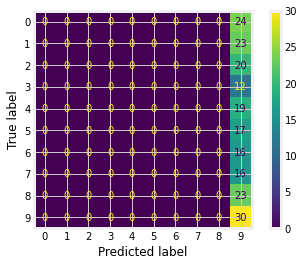

In [178]:
y_pred_test = svc_classifer.predict(test_x)
cr = classification_report(test_y, y_pred_test)
print(cr)
cf = confusion_matrix(test_y,y_pred_test,labels=[i for i in range(10) ])
ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=[i for i in range(10) ]).plot()
plt.show() 